In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import json
from PIL import Image

In [2]:
import cv2
from IPython.display import display, Image

def draw_annotation(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    
    # Extract the annotation details
    filename = annotation["FileName"]
    annotations = annotation["Annotations"]
    
    # Process each annotation
    for annot in annotations:
        bounding_box = annot["BoundingBox"]
        class_name = annot["classname"]
        
        # Draw the bounding box
        x_min, y_min, x_max, y_max = bounding_box
        print(x_min, y_min, x_max, y_max)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Add the class label
        text = f"{class_name}"
        cv2.putText(image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        #make a dot at x_min, y_min and x_max, y_max
        cv2.circle(image, (x_min, y_min), 5, (0, 0, 255), -1)
        cv2.circle(image, (x_max, y_max), 5, (255, 0, 0), -1)
    
    # Save the image with annotations
    annotated_image_path = "annotated_image.jpg"
    cv2.imwrite(annotated_image_path, image)
    
    # Display the image in the notebook
    display(Image(filename=annotated_image_path))


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(dataloader, x):
    # Rufen Sie das x-te Element aus dem Dataloader ab
    images, annotations = next(iter(dataloader))
    image = images[x]
    boxes = annotations[x]['annotations']

    # Erstellen Sie eine neue Figur und Achse
    fig, ax = plt.subplots(1)

    # Zeigen Sie das Bild in der Achse an
    ax.imshow(image.permute(1, 2, 0))

    # Iterieren Sie über die Bounding Boxes und zeichnen Sie sie als Rechtecke in der Achse
    for box in boxes:
        x_min, y_min, x_max, y_max = box['bbox']
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


    # Zeigen Sie die visualisierten Bounding Boxes an
    plt.show()

{'FileName': '1861.jpg', 'NumOfAnno': 3, 'Annotations': [{'isProtected': False, 'ID': 999198335109255808, 'BoundingBox': [518, 116, 938, 632], 'classname': 'face_other_covering', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 248677733460168320, 'BoundingBox': [542, 300, 932, 613], 'classname': 'mask_colorful', 'Confidence': 1, 'Attributes': {}}]}
518 116 938 632
542 300 932 613


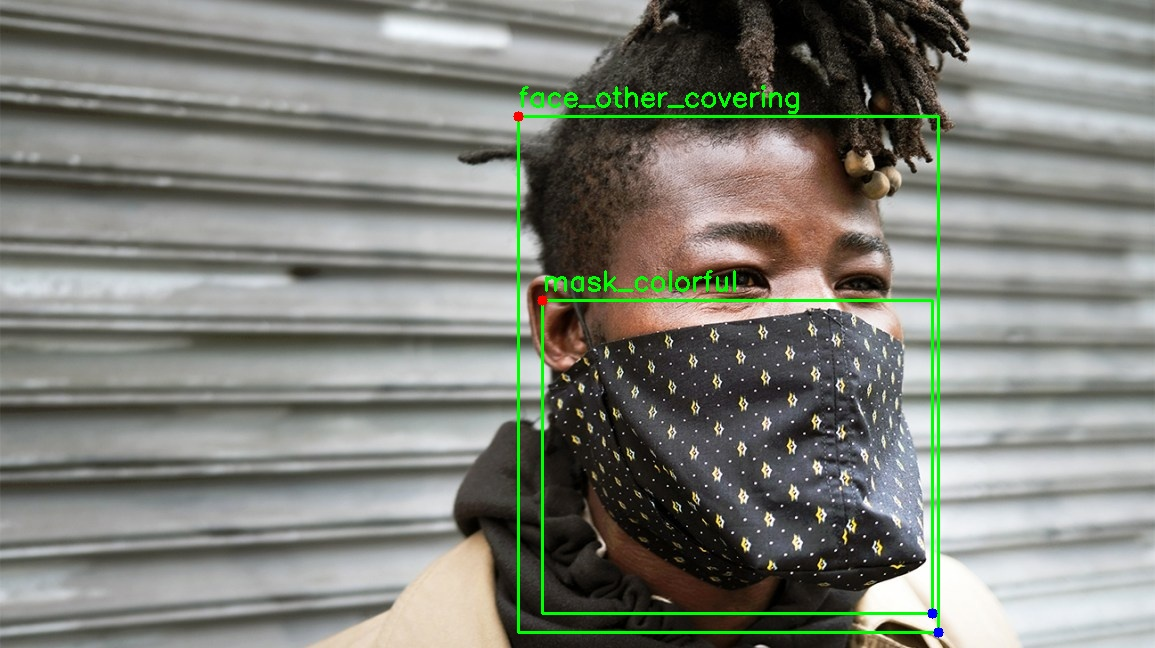

In [4]:
number = 1861


image_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images\\{number}.jpg".format(number=number)

#read json file
import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations\\{number}.jpg.json'.format(number=number)) as json_file:
    annotation = json.load(json_file)

print(annotation)

draw_annotation(image_path, annotation)

In [5]:
#open the json file at Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json

import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json') as json_file:
    meta = json.load(json_file)

#copunt the entries in classes
print(len(meta["classes"]))

20


In [6]:
#iterate through all annotation files and search for invalid bounding boxes
import os
import json
from PIL import Image

# Get the path to the annotations
annotations_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations"

# Get the path to the images
images_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images"

# Get the list of all annotations
annotation_files = os.listdir(annotations_path)


# # Iterate through each annotation file
# for annotation_file in annotation_files:
#     # Build the path to the annotation file
#     annotation_file_path = os.path.join(annotations_path, annotation_file)
    
#     # Open the annotation file
#     with open(annotation_file_path) as file:
#         # Load the annotation file
#         annotation = json.load(file)
        
#         # Get the image filename
#         image_filename = annotation["FileName"]
        
#         # Build the path to the image file
#         image_file_path = os.path.join(images_path, image_filename)
        
#         # Open the image
#         image = Image.open(image_file_path)
        
#         # Get the image size
#         image_width, image_height = image.size
        
#         # Get the list of annotations
#         annotations = annotation["Annotations"]
        
#         # Iterate through each annotation
#         for annotation in annotations:
#             # Get the bounding box coordinates
#             x_min = annotation["BoundingBox"][0]
#             y_min = annotation["BoundingBox"][1]
#             x_max = annotation["BoundingBox"][2]
#             y_max = annotation["BoundingBox"][3]

#             print(x_min, x_max, y_min, y_max)
            
#             # Check if any coordinate exceeds the image boundaries
#             if x_min > image_width or y_min > image_height or x_max > image_width or y_max > image_height:
#                 print("Invalid bounding box coordinates in file:", image_file_path)
#                 break

#             if x_min > x_max or y_min > y_max:
#                 print("Invalid bounding box coordinates in file:", image_file_path)
                #break

In [7]:
import os
import PIL.Image as Image

class MaskDetectionDataset(Dataset):
    def __init__(self, root_dir, target_size=(600, 900)):
        self.root_dir = root_dir
        self.annotations = []
        self.target_size = target_size
        self.load_annotations()

    def load_annotations(self):
        annotation_files = os.listdir(f"{self.root_dir}/annotations")
        for file_name in annotation_files:
            with open(f"{self.root_dir}/annotations/{file_name}", "r") as f:
                annotation_data = json.load(f)
                annotations = annotation_data["Annotations"]
                file_name = annotation_data["FileName"]
                # for annotation in annotations:
                #     annotation["FileName"] = file_name
                self.annotations.append((annotations, file_name))
                #chack the boxes are valid
                for annotation in annotations:
                    boxes = annotation["BoundingBox"]
                    if boxes[0] >= boxes[2] or boxes[1] >= boxes[3]:
                        print("Invalid bounding box coordinates in file:", file_name)
                        break

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotations = self.annotations[idx][0]
        file_name = self.annotations[idx][1]
        image_path = f"{self.root_dir}/images/{file_name}"
        image = Image.open(image_path).convert("RGB")
        original_image_width, original_image_height = image.size
        image = F.resize(image, self.target_size)
        image = F.to_tensor(image)

        boxes = []
        labels = []
        for annotation in annotations:
            box = annotation["BoundingBox"]
            if box[0] < box[2] and box[1] < box[3]:
                # Resize the bounding box coordinates
                box_resized = [
                    box[0] * self.target_size[0] / original_image_width,
                    box[1] * self.target_size[1] / original_image_height,
                    box[2] * self.target_size[0] / original_image_width,
                    box[3] * self.target_size[1] / original_image_height
                ]
                boxes.append(box_resized)
                class_name = annotation["classname"]
                class_label = 1 if class_name == "face_with_mask" else 0
                labels.append(class_label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        targets = {
            "boxes": boxes,
            "labels": labels
        }

        return {
            "image": image,
            "targets": targets
        }






In [8]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [9]:
dataset = MaskDetectionDataset("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask")

#dataset.annotations[1][0]

dataset.__getitem__(1)

{'image': tensor([[[0.9765, 0.9804, 0.9804,  ..., 0.8510, 0.8627, 0.8745],
          [0.9843, 0.9843, 0.9843,  ..., 0.8745, 0.8863, 0.8980],
          [0.9922, 0.9882, 0.9882,  ..., 0.9098, 0.9216, 0.9294],
          ...,
          [0.7333, 0.7333, 0.7333,  ..., 0.2667, 0.2588, 0.2549],
          [0.7294, 0.7333, 0.7333,  ..., 0.2588, 0.2510, 0.2471],
          [0.7255, 0.7294, 0.7333,  ..., 0.2510, 0.2471, 0.2431]],
 
         [[0.9922, 0.9961, 1.0000,  ..., 0.6941, 0.7059, 0.7176],
          [0.9922, 0.9961, 1.0000,  ..., 0.7176, 0.7294, 0.7412],
          [0.9922, 0.9961, 1.0000,  ..., 0.7569, 0.7686, 0.7765],
          ...,
          [0.6902, 0.6980, 0.7020,  ..., 0.1569, 0.1490, 0.1451],
          [0.6863, 0.6980, 0.7020,  ..., 0.1490, 0.1412, 0.1373],
          [0.6824, 0.6941, 0.7020,  ..., 0.1412, 0.1373, 0.1333]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.4510, 0.4627, 0.4745],
          [1.0000, 1.0000, 0.9961,  ..., 0.4745, 0.4863, 0.4980],
          [0.9961, 0.9922, 0.98

In [10]:
#PARAMETERS
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
TRAIN_PERCENTAGE = .01

In [11]:


# Split the dataset into training and validation sets (adjust the split ratio as needed)
train_size = int(TRAIN_PERCENTAGE * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [12]:
dataset[1]

{'image': tensor([[[0.9765, 0.9804, 0.9804,  ..., 0.8510, 0.8627, 0.8745],
          [0.9843, 0.9843, 0.9843,  ..., 0.8745, 0.8863, 0.8980],
          [0.9922, 0.9882, 0.9882,  ..., 0.9098, 0.9216, 0.9294],
          ...,
          [0.7333, 0.7333, 0.7333,  ..., 0.2667, 0.2588, 0.2549],
          [0.7294, 0.7333, 0.7333,  ..., 0.2588, 0.2510, 0.2471],
          [0.7255, 0.7294, 0.7333,  ..., 0.2510, 0.2471, 0.2431]],
 
         [[0.9922, 0.9961, 1.0000,  ..., 0.6941, 0.7059, 0.7176],
          [0.9922, 0.9961, 1.0000,  ..., 0.7176, 0.7294, 0.7412],
          [0.9922, 0.9961, 1.0000,  ..., 0.7569, 0.7686, 0.7765],
          ...,
          [0.6902, 0.6980, 0.7020,  ..., 0.1569, 0.1490, 0.1451],
          [0.6863, 0.6980, 0.7020,  ..., 0.1490, 0.1412, 0.1373],
          [0.6824, 0.6941, 0.7020,  ..., 0.1412, 0.1373, 0.1333]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.4510, 0.4627, 0.4745],
          [1.0000, 1.0000, 0.9961,  ..., 0.4745, 0.4863, 0.4980],
          [0.9961, 0.9922, 0.98

In [13]:
len(dataset)

4326

In [14]:
def collate_fn(batch):
    images = [item["image"] for item in batch]
    targets = [item["targets"] for item in batch if item["targets"]]

    if targets:
        targets = [{k: v for k, v in target.items()} for target in targets]  # Remove the "to(device)" part
        return {
            "image": torch.stack(images),
            "targets": targets
        }
    else:
        return {
            "image": torch.stack(images),
            "targets": []  # Return an empty list if targets is empty
        }

In [15]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [16]:
#get the first batch
out = next(iter(train_data_loader))

out

{'image': tensor([[[[0.5725, 0.5686, 0.5686,  ..., 0.2824, 0.2824, 0.2824],
           [0.5647, 0.5647, 0.5647,  ..., 0.2784, 0.2784, 0.2784],
           [0.5647, 0.5647, 0.5647,  ..., 0.2784, 0.2784, 0.2824],
           ...,
           [0.5725, 0.5725, 0.5686,  ..., 0.8118, 0.8118, 0.8118],
           [0.5725, 0.5686, 0.5686,  ..., 0.8118, 0.8118, 0.8118],
           [0.5725, 0.5686, 0.5647,  ..., 0.8118, 0.8118, 0.8118]],
 
          [[0.5686, 0.5647, 0.5647,  ..., 0.3098, 0.3098, 0.3098],
           [0.5569, 0.5569, 0.5569,  ..., 0.3059, 0.3059, 0.3059],
           [0.5569, 0.5569, 0.5569,  ..., 0.3059, 0.3059, 0.3098],
           ...,
           [0.5686, 0.5686, 0.5647,  ..., 0.7294, 0.7294, 0.7294],
           [0.5686, 0.5647, 0.5647,  ..., 0.7294, 0.7294, 0.7294],
           [0.5686, 0.5647, 0.5608,  ..., 0.7294, 0.7294, 0.7294]],
 
          [[0.5922, 0.5882, 0.5882,  ..., 0.3333, 0.3333, 0.3333],
           [0.5804, 0.5804, 0.5804,  ..., 0.3294, 0.3294, 0.3294],
           [0.5

In [17]:
dataset.__len__()

4326

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [44]:
import time

def train(model, data_loader, optimizer, device):
    model.train()
    total_iterations = len(data_loader)
    start_time = time.time()
    for iteration, batch in enumerate(data_loader, 1):
        images = batch["image"]
        targets = batch["targets"]
        #print(targets)

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / iteration
        remaining_iterations = total_iterations - iteration
        eta = avg_time_per_iteration * remaining_iterations

        print(f"Iteration: {iteration}/{total_iterations}, Remaining: {remaining_iterations}, ETA: {eta:.2f} seconds, Loss: {losses:.4f}", end="\r")




#EVAL RETurNT ANDERE WERTE GOOGELN
#auch checken im dataset welche klassen zgeordnet werden und wieviele klassen angegeben werden
def validate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    criterion = torch.nn.CrossEntropyLoss()  # Use appropriate loss function

    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"]
            targets = batch["targets"]

            images = [img.to(device) for img in images]
            labels = [target['labels'].to(device) for target in targets]

            outputs = model(images)
            predicted_labels = [output['labels'] for output in outputs]
            predicted_labels = torch.cat(predicted_labels)

            # Flatten the ground truth labels and convert them to 'Long' type
            flattened_labels = torch.cat(labels)
            flattened_labels = flattened_labels.long()

            loss = criterion(outputs['labels'], flattened_labels)
            total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    return average_loss




In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

device

device(type='cuda')

In [46]:
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(NUM_EPOCHS):
    train(model, train_data_loader, optimizer, device)
    val_loss = validate(model, val_data_loader, device)
    print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")


TypeError: list indices must be integers or slices, not str

In [ ]:
dataset.__getitem__(1)

In [ ]:
torch.save(model.state_dict(), "mask_detection_model.pth")
